# 1. Import Thư viện và Cấu hình

In [1]:
# Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Cấu hình hiển thị
%matplotlib inline
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')


# 2. Tải Dữ liệu

In [2]:
RAW_PATH = '../data/raw/ratings_Beauty.csv'
PROCESSED_PATH = '../data/processed'

if not os.path.exists(PROCESSED_PATH):
    os.makedirs(PROCESSED_PATH)
    
print(f"Đang tải dữ liệu từ {RAW_PATH}")

try:
    raw_data = np.genfromtxt(RAW_PATH, delimiter=',', dtype=str, encoding='utf-8', skip_header=1)
    user_ids_raw = raw_data[:, 0]
    product_ids_raw = raw_data[:, 1]
    ratings_raw = raw_data[:, 2].astype(float)
    print("Dữ liệu đã được tải thành công!")
    print(f"Kích thước dữ liệu: {raw_data.shape}")
except Exception as e:
    print(f"Lỗi khi tải dữ liệu: {e}")


Đang tải dữ liệu từ ../data/raw/ratings_Beauty.csv
Dữ liệu đã được tải thành công!
Kích thước dữ liệu: (2023070, 4)


# 3. Lọc user không tích cực

In [3]:
MIN_RATINGS_PER_USER = 5

# 1. Đếm số rating của mỗi User
unique_users, counts = np.unique(user_ids_raw, return_counts=True)

# 2. Tìm danh sách User đạt chuẩn (Active Users)
active_users_mask = counts >= MIN_RATINGS_PER_USER
active_user_ids = unique_users[active_users_mask]

# Tạo set để tra cứu nhanh
active_user_set = set(active_user_ids)

print(f"Số lượng user tích cực (>={MIN_RATINGS_PER_USER} rating): {len(active_user_ids)}")
print(f"Đã loại bỏ {len(unique_users) - len(active_user_ids)} user không tích cực.")

# 3. Lọc dữ liệu gốc, chỉ giữ lại dòng chứa Active Users
mask_keep = np.isin(user_ids_raw, active_user_ids)

filtered_users = user_ids_raw[mask_keep]
filtered_products = product_ids_raw[mask_keep]
filtered_ratings = ratings_raw[mask_keep]

print(f"Kích thước dữ liệu sau lọc: {filtered_users.shape}")
print(f"Số lượng rating còn lại: {len(filtered_ratings)}")


Số lượng user tích cực (>=5 rating): 52374
Đã loại bỏ 1157897 user không tích cực.
Kích thước dữ liệu sau lọc: (469771,)
Số lượng rating còn lại: 469771


# 4. Mã hóa ID

In [4]:
# 1. Mã hóa User
unique_users_final, user_indices = np.unique(filtered_users, return_inverse=True)

# 2. Mã hóa Product
unique_products_final, product_indices = np.unique(filtered_products, return_inverse=True)

n_users = len(unique_users_final)
n_items = len(unique_products_final)

print(f"Kích thước ma trận cuối cùng: {n_users} Users x {n_items} Products")
print(f"Độ thưa sau lọc: {1 - (len(filtered_ratings) / (n_users * n_items)):.6f}")

# Kiểm tra mẫu
print("\nKiểm tra mẫu:")
print(f"User gốc: {filtered_users[0]} -> Mã hóa: {user_indices[0]}")
print(f"Product gốc: {filtered_products[0]} -> Mã hóa: {product_indices[0]}")


Kích thước ma trận cuối cùng: 52374 Users x 121291 Products
Độ thưa sau lọc: 0.999926

Kiểm tra mẫu:
User gốc: A3IAAVS479H7M7 -> Mã hóa: 34827
Product gốc: 0737104473 -> Mã hóa: 0


# 5. Phân tích và Trực quan hóa Dữ liệu sau khi Lọc

Độ thưa (Sparsity) mới: 99.9926%
Mật độ (Density) mới: 0.0074%


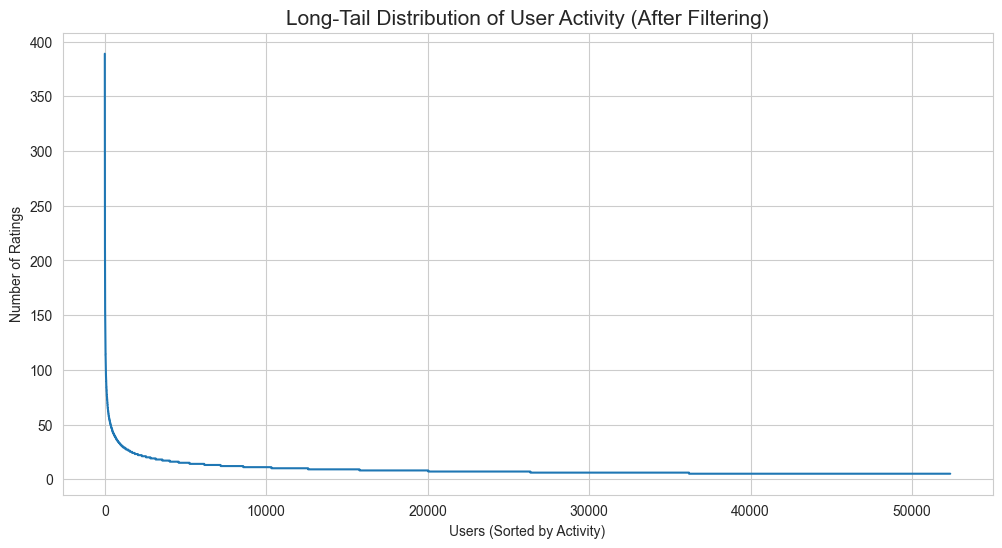


Sau khi lọc, mỗi user có ít nhất 5 ratings.
User có nhiều ratings nhất: 389 ratings.
User có ít ratings nhất: 5 ratings.

Phân tích Pareto cho user sau khi lọc:
Số lượng user tích cực: 52374
Số lượng user tạo ra 80% ratings: 34018
Tỷ lệ: 64.95% user chiếm 80% tổng rating.


In [5]:
# 1. Phân tích độ thưa 
new_sparsity = 1 - (len(filtered_ratings) / (n_users * n_items))
print(f"Độ thưa (Sparsity) mới: {new_sparsity * 100:.4f}%")
print(f"Mật độ (Density) mới: {(1 - new_sparsity) * 100:.4f}%")

# 2. Phân tích Long-Tail cho User sau khi lọc
_, user_counts_filtered = np.unique(filtered_users, return_counts=True)
sorted_user_counts_filtered = np.sort(user_counts_filtered)[::-1]

plt.figure(figsize=(12, 6))
plt.plot(sorted_user_counts_filtered)
plt.title("Long-Tail Distribution of User Activity (After Filtering)", fontsize=15)
plt.xlabel("Users (Sorted by Activity)")
plt.ylabel("Number of Ratings")
plt.show()

print(f"\nSau khi lọc, mỗi user có ít nhất {MIN_RATINGS_PER_USER} ratings.")
print(f"User có nhiều ratings nhất: {np.max(user_counts_filtered)} ratings.")
print(f"User có ít ratings nhất: {np.min(user_counts_filtered)} ratings.")

# 3. Phân tích Pareto cho User sau khi lọc
cumulative_user_ratings_filtered = np.cumsum(sorted_user_counts_filtered)
total_user_ratings_filtered = cumulative_user_ratings_filtered[-1]
cumulative_user_percent_filtered = (cumulative_user_ratings_filtered / total_user_ratings_filtered) * 100

index_80_percent_users_filtered = np.searchsorted(cumulative_user_percent_filtered, 80.0)

num_users_top_80_filtered = index_80_percent_users_filtered + 1
total_users_filtered = len(sorted_user_counts_filtered)
user_percent_making_80_filtered = (num_users_top_80_filtered / total_users_filtered) * 100

print("\nPhân tích Pareto cho user sau khi lọc:")
print(f"Số lượng user tích cực: {total_users_filtered}")
print(f"Số lượng user tạo ra 80% ratings: {num_users_top_80_filtered}")
print(f"Tỷ lệ: {user_percent_making_80_filtered:.2f}% user chiếm 80% tổng rating.")


### Nhận xét sau khi lọc với ngưỡng = 5

Sau khi thực hiện bước lọc đầu tiên với `MIN_RATINGS_PER_USER = 5`, chúng ta có một vài kết quả đáng chú ý:

*   **Cải thiện về chất lượng**: Chúng ta đã thành công loại bỏ những người dùng chỉ có 1-4 ratings. Giờ đây, người dùng có ít đánh giá nhất cũng đã có **5 đánh giá**. Điều này giúp loại bỏ bớt "nhiễu" và các tín hiệu yếu.
*   **Phân phối người dùng**: Phân tích Pareto cho thấy cần **64.95%** số người dùng tích cực nhất để tạo ra 80% tổng số lượt đánh giá. Con số này không thay đổi nhiều so với trước khi lọc, cho thấy cấu trúc phân phối hoạt động của người dùng vẫn còn rất dàn trải.
*   **Vấn đề về mật độ**: Mặc dù đã lọc, mật độ dữ liệu (`Density`) chỉ tăng nhẹ lên **0.0074%**. Con số này vẫn còn **cực kỳ thấp**. Ma trận User-Item vẫn còn rất thưa, điều này sẽ là một thách thức lớn cho các thuật toán học máy.

**Kết luận:** Việc lọc với ngưỡng `5` là một bước đi đúng hướng nhưng **chưa đủ** để giải quyết triệt để vấn đề về độ thưa. Để xây dựng một mô hình tốt hơn, chúng ta cần một tập dữ liệu "đặc" hơn nữa. Điều này dẫn đến câu hỏi: *Đâu là ngưỡng lọc tối ưu để cân bằng giữa việc tăng mật độ và không làm mất quá nhiều dữ liệu?*

Phần tiếp theo sẽ giúp chúng ta trả lời câu hỏi này.

# 6. Tìm ngưỡng lọc tối ưu (Optimal Threshold)
Dưới đây là đoạn code thử nghiệm các ngưỡng lọc khác nhau để phân tích sự đánh đổi.
- **Mục tiêu**: Tăng mật độ dữ liệu (density).
- **Đánh đổi**: Việc tăng ngưỡng lọc sẽ làm giảm số lượng người dùng và tổng số ratings còn lại trong tập dữ liệu.

Chúng ta sẽ trực quan hóa các chỉ số sau theo từng ngưỡng:
1.  **Mật độ dữ liệu (Density)**: Càng cao càng tốt.
2.  **Số lượng người dùng còn lại**: Càng cao càng tốt.
3.  **Số lượng ratings còn lại**: Càng cao càng tốt.

Analyzing threshold: 5...
 -> Density: 0.0074%, Users: 52374, Ratings: 469771
Analyzing threshold: 10...
 -> Density: 0.0235%, Users: 12595, Ratings: 222897
Analyzing threshold: 15...
 -> Density: 0.0488%, Users: 5249, Ratings: 138204
Analyzing threshold: 20...
 -> Density: 0.0824%, Users: 2826, Ratings: 97860
Analyzing threshold: 25...
 -> Density: 0.1279%, Users: 1691, Ratings: 73188
Analyzing threshold: 30...
 -> Density: 0.1793%, Users: 1136, Ratings: 58289
Analyzing threshold: 50...
 -> Density: 0.4753%, Users: 361, Ratings: 29559


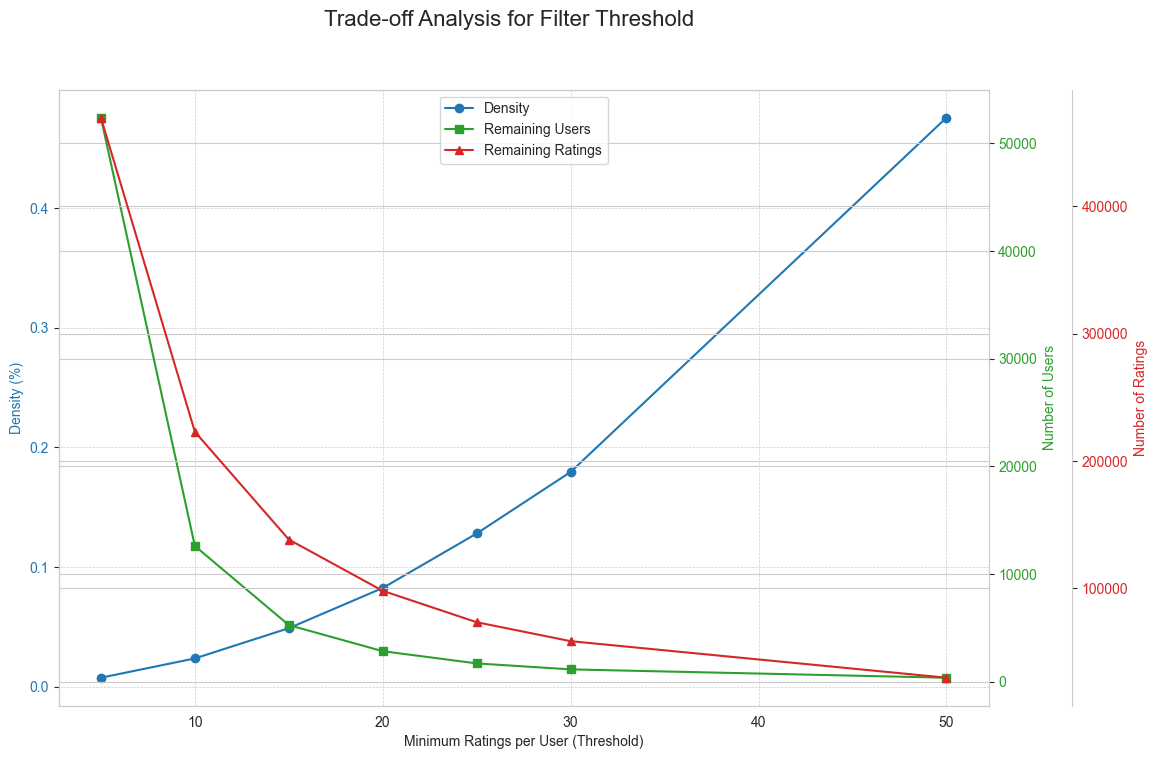

In [6]:

def analyze_threshold(min_ratings_threshold, user_ids_data, product_ids_data, ratings_data):
    """
    Hàm phân tích ảnh hưởng của một ngưỡng lọc.
    Trả về: (density, remaining_users, remaining_ratings)
    """
    # 1. Lọc user
    unique_users, counts = np.unique(user_ids_data, return_counts=True)
    active_user_ids = unique_users[counts >= min_ratings_threshold]
    
    if len(active_user_ids) == 0:
        return 0, 0, 0

    # 2. Lọc dữ liệu
    mask_keep = np.isin(user_ids_data, active_user_ids)
    
    current_users = user_ids_data[mask_keep]
    current_products = product_ids_data[mask_keep]
    current_ratings = ratings_data[mask_keep]

    # 3. Tính toán chỉ số
    n_users = len(np.unique(current_users))
    n_items = len(np.unique(current_products))
    n_ratings = len(current_ratings)
    
    if n_users == 0 or n_items == 0:
        return 0, 0, 0
        
    density = (n_ratings / (n_users * n_items)) * 100
    
    return density, n_users, n_ratings

# --- THỬ NGHIỆM CÁC NGƯỠNG ---
thresholds = [5, 10, 15, 20, 25, 30, 50]
results = []

for t in thresholds:
    print(f"Analyzing threshold: {t}...")
    density, rem_users, rem_ratings = analyze_threshold(t, user_ids_raw, product_ids_raw, ratings_raw)
    results.append((density, rem_users, rem_ratings))
    print(f" -> Density: {density:.4f}%, Users: {rem_users}, Ratings: {rem_ratings}")

results = np.array(results)

# --- TRỰC QUAN HÓA KẾT QUẢ TRÊN CÙNG 1 BIỂU ĐỒ ---
fig, ax1 = plt.subplots(figsize=(12, 8))

# Density
color = 'tab:blue'
ax1.set_xlabel('Minimum Ratings per User (Threshold)')
ax1.set_ylabel('Density (%)', color=color)
ax1.plot(thresholds, results[:, 0], marker='o', color=color, label='Density')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remaining Users
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Number of Users', color=color)
ax2.plot(thresholds, results[:, 1], marker='s', color=color, label='Remaining Users')
ax2.tick_params(axis='y', labelcolor=color)

# Remaining Ratings
ax3 = ax1.twinx()
color = 'tab:red'
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Number of Ratings', color=color)
ax3.plot(thresholds, results[:, 2], marker='^', color=color, label='Remaining Ratings')
ax3.tick_params(axis='y', labelcolor=color)


fig.suptitle('Trade-off Analysis for Filter Threshold', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper center')

plt.show()



### Phân tích Biểu đồ

Biểu đồ trên cho thấy sự đánh đổi rõ ràng giữa các chỉ số khi chúng ta tăng ngưỡng lọc (`Minimum Ratings per User`):

1.  **Mật độ (Density - màu xanh dương)**: Tăng theo hàm mũ. Điều này rất tốt, vì mục tiêu chính của chúng ta là giảm độ thưa của dữ liệu.
2.  **Số lượng Users và Ratings (màu xanh lá và đỏ)**: Giảm rất nhanh, đặc biệt là ở các ngưỡng thấp.

### Tìm "Điểm Uốn" (Elbow Point)

Chúng ta cần tìm một "điểm uốn" nơi mà chúng ta có được sự gia tăng mật độ đáng kể mà không phải hy sinh quá nhiều dữ liệu.

*   **Từ 5 đến 10**: Mật độ tăng hơn **3 lần** (từ 0.0074% lên 0.0235%), nhưng chúng ta mất hơn một nửa số ratingsvà 75% user. Đây là một sự đánh đổi lớn.
*   **Từ 10 đến 15**: Mật độ tiếp tục tăng hơn **2 lần** (từ 0.0235% lên 0.0488%). Lượng dữ liệu mất đi vẫn đáng kể nhưng tốc độ giảm đã chậm lại so với bước trước.
*   **Từ 15 đến 20**: Mật độ tăng khoảng **1.7 lần**. Tại điểm này, đường cong mật độ bắt đầu "thoải" hơn, nghĩa là lợi ích thu được (tăng mật độ) bắt đầu giảm dần, trong khi lượng dữ liệu mất đi vẫn còn nhiều.

### Kết luận và Lựa chọn

Ngưỡng **`15`** có vẻ là điểm cân bằng tốt nhất:

*   **Lợi ích**: Nó làm tăng mật độ dữ liệu lên **gần 7 lần** so với ngưỡng `5` ban đầu (từ 0.0074% lên 0.0488%), một sự cải thiện rất đáng kể.
*   **Chi phí**: Chúng ta giữ lại được **5,249 người dùng** và **138,204 lượt đánh giá**. Mặc dù đã giảm nhiều so với ban đầu, đây vẫn là một lượng dữ liệu đủ lớn để huấn luyện nhiều loại mô hình.

Do đó, chúng ta sẽ chọn **`15`** làm ngưỡng lọc cuối cùng để chuẩn bị dữ liệu cho các bước tiếp theo.

# 7. Lọc lại user với ngưỡng tối ưu

In [7]:
# 1. Ngưỡng tối ưu
OPTIMAL_THRESHOLD = 15

print(f"Áp dụng ngưỡng tối ưu: {OPTIMAL_THRESHOLD} ratings mỗi user.")

# 2. Lọc lại dữ liệu với ngưỡng tối ưu
unique_users, counts = np.unique(user_ids_raw, return_counts=True)

active_users_mask = counts >= OPTIMAL_THRESHOLD
active_user_ids = unique_users[active_users_mask]

mask_keep = np.isin(user_ids_raw, active_user_ids)

final_users_str = user_ids_raw[mask_keep]
final_products_str = product_ids_raw[mask_keep]
final_ratings = ratings_raw[mask_keep]

print(f"Số lượng rating sau khi lọc với ngưỡng {OPTIMAL_THRESHOLD}: {len(final_ratings)}")

# 3. Mã hóa lại ID
unique_users_final, user_indices = np.unique(final_users_str, return_inverse=True)
unique_products_final, product_indices = np.unique(final_products_str, return_inverse=True)

n_users_final = len(unique_users_final)
n_items_final = len(unique_products_final)
final_density = len(final_ratings) / (n_users_final * n_items_final)

print(f"Kích thước ma trận cuối cùng: {n_users_final} Users x {n_items_final} Products")
print(f"Mật độ cuối cùng: {final_density*100:.4f}%")


Áp dụng ngưỡng tối ưu: 15 ratings mỗi user.
Số lượng rating sau khi lọc với ngưỡng 15: 138204
Kích thước ma trận cuối cùng: 5249 Users x 53970 Products
Mật độ cuối cùng: 0.0488%


# 8. Lưu Dữ liệu đã xử lý

In [8]:
np.save(os.path.join(PROCESSED_PATH, 'user_indices.npy'), user_indices)
np.save(os.path.join(PROCESSED_PATH, 'product_indices.npy'), product_indices)
np.save(os.path.join(PROCESSED_PATH, 'ratings.npy'), final_ratings)

np.save(os.path.join(PROCESSED_PATH, 'user_ids_map.npy'), unique_users_final)
np.save(os.path.join(PROCESSED_PATH, 'product_ids_map.npy'), unique_products_final)

print(f"\nĐã lưu 5 tệp đã xử lý vào thư mục: {PROCESSED_PATH}")
print("Các tệp bao gồm:")
print("- user_indices.npy")
print("- product_indices.npy")
print("- ratings.npy")
print("- user_ids_map.npy (để tra cứu ID user gốc)")
print("- product_ids_map.npy (để tra cứu ID product gốc)")



Đã lưu 5 tệp đã xử lý vào thư mục: ../data/processed
Các tệp bao gồm:
- user_indices.npy
- product_indices.npy
- ratings.npy
- user_ids_map.npy (để tra cứu ID user gốc)
- product_ids_map.npy (để tra cứu ID product gốc)
